#  Finding the best location to open an restaurant in Los Angeles

In this notebook we will decide to select best places to open a restaurant in Los Angeles using clustering.    

We will extract the data from the website contains information about the coordinate of Los Angeles neighborhood. Before that, the required libraries will be imported.    

### Import All Required Libraries 

In [282]:
import pandas as pd
import numpy as np


from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize 

import folium

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import seaborn as sns

from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

import warnings
warnings.filterwarnings('ignore')

---
# 1) Available Data 

# A. Neighborhood Name, Area size and, Coordinates
in this section, we need to get the name, area size, latitude and the longitude of each neighborhood. We will use data from the link https://usc.data.socrata.com/api/views/9utn-waje/rows.csv?accessType=DOWNLOAD which contains Los Angeles county neighborhoods information.



So, we will extract the required data from the web page. 

In [283]:
la_county=pd.read_csv('https://usc.data.socrata.com/api/views/9utn-waje/rows.csv?accessType=DOWNLOAD')
la_county.head(2)

,set,slug,the_geom,kind,external_i,name,display_na,sqmi,type,name_1,slug_1,latitude,longitude,location
0,L.A. County Neighborhoods (Current),acton,MULTIPOLYGON (((-118.20261747920541 34.5389897...,L.A. County Neighborhood (Current),acton,Acton,Acton L.A. County Neighborhood (Current),39.339109,unincorporated-area,NaN,NaN,-118.169810,34.497355,POINT(34.497355239240846 -118.16981019229348)
1,L.A. County Neighborhoods (Current),adams-normandie,MULTIPOLYGON (((-118.30900800000012 34.0374109...,L.A. County Neighborhood (Current),adams-normandie,Adams-Normandie,Adams-Normandie L.A. County Neighborhood (Curr...,0.805350,segment-of-a-city,NaN,NaN,-118.300208,34.031461,POINT(34.031461499124156 -118.30020800000011)


As we will work on the data related to the city of Los Angeles, the data will be limited to the rows contain `segment-of-a-city` in `type` column.  Also, the index due to deleted rows should be reset. 

In [284]:
la_city=la_county[la_county['type']=='segment-of-a-city']
la_city=la_city.reset_index()
la_city.head(3)

,index,set,slug,the_geom,kind,external_i,name,display_na,sqmi,type,name_1,slug_1,latitude,longitude,location
0,1,L.A. County Neighborhoods (Current),adams-normandie,MULTIPOLYGON (((-118.30900800000012 34.0374109...,L.A. County Neighborhood (Current),adams-normandie,Adams-Normandie,Adams-Normandie L.A. County Neighborhood (Curr...,0.805350,segment-of-a-city,NaN,NaN,-118.300208,34.031461,POINT(34.031461499124156 -118.30020800000011)
1,10,L.A. County Neighborhoods (Current),arleta,MULTIPOLYGON (((-118.42201500000009 34.2241029...,L.A. County Neighborhood (Current),arleta,Arleta,Arleta L.A. County Neighborhood (Current),3.096179,segment-of-a-city,NaN,NaN,-118.430757,34.243100,POINT(34.243099999121583 -118.4307575)
2,11,L.A. County Neighborhoods (Current),arlington-heights,"MULTIPOLYGON (((-118.315909 34.05261099912384,...",L.A. County Neighborhood (Current),arlington-heights,Arlington Heights,Arlington Heights L.A. County Neighborhood (Cu...,1.031415,segment-of-a-city,NaN,NaN,-118.323408,34.044910,POINT(34.04491049912405 -118.3234085)


We need only name of neighborhood, area size and coordinates. After extraction these columns, for better understanding column names will be replaced. It should be noted that column names related to coordinates are wrong and need to be replaced.   

In [285]:
df_la=la_city[['name', 'sqmi','latitude','longitude']]
df_la.rename(columns={'name':'Neighborhood', 'sqmi':'Square_Mile','latitude':'Longitude','longitude':'Latitude'},inplace=True)
df_la.head()

,Neighborhood,Square_Mile,Longitude,Latitude
0,Adams-Normandie,0.805350,-118.300208,34.031461
1,Arleta,3.096179,-118.430757,34.243100
2,Arlington Heights,1.031415,-118.323408,34.044910
3,Atwater Village,1.776894,-118.262373,34.131066
4,Vermont-Slauson,1.442453,-118.290358,33.983914


# B. Crime data

Violent crime is defined as homicide, rape, aggravated assault and, robbery. Bear in mind that in areas with relatively low populations, a small number of crimes can generate a large per capita rate. For that reason, the below data frames contain  per capita statistics for property and violent crimes.<br>The data extracted from both websites for property and violent crime, respectively. As we expect, some corrections are needed to use these crime data. 
* http://maps.latimes.com/neighborhoods/property-crime/neighborhood/list/ 
* https://maps.latimes.com/neighborhoods/violent-crime/neighborhood/list/


In the next step, crime data will be extracted from two above links.

### B.1. Property Crime

In [286]:
url='http://maps.latimes.com/neighborhoods/property-crime/neighborhood/list/'
tables = pd.read_html(url)
df_prop_cr=tables[3]
df_prop_cr=df_prop_cr[['Neighborhood','Per Capita']]
df_prop_cr.rename(columns={'Per Capita':'Property Crime Per Capita'},inplace=True)
df_prop_cr['Property Crime Per Capita']=df_prop_cr['Property Crime Per Capita'].astype(np.float64)
df_prop_cr.head()

,Neighborhood,Property Crime Per Capita
0,Fairfax,345.8
1,Beverly Grove,294.0
2,Chesterfield Square,291.4
3,Westchester,247.6
4,Leimert Park,242.1


### B.2. Violent Crime

In [287]:
url='https://maps.latimes.com/neighborhoods/violent-crime/neighborhood/list/'
tables = pd.read_html(url)
df_vio_cr=tables[3]
df_vio_cr=df_vio_cr[['Neighborhood','Per Capita']]
df_vio_cr.rename(columns={'Per Capita':'Violent Crime Per Capita'},inplace=True)
df_vio_cr['Violent Crime Per Capita']=df_vio_cr['Violent Crime Per Capita'].astype(np.float64)
df_vio_cr.head()

,Neighborhood,Violent Crime Per Capita
0,Chesterfield Square,191.2
1,Harvard Park,133.2
2,Green Meadows,119.4
3,Manchester Square,112.3
4,Vermont Knolls,110.4


# C. Income Rate
Income as one of main parameters in demography will be used. The required data will be extracted from website https://maps.latimes.com/neighborhoods/income/median/neighborhood/list/.<br>Some corrections are needed to use the income data such as removing`,` and `$` from `Median Income`.

In [288]:
url='https://maps.latimes.com/neighborhoods/income/median/neighborhood/list/'
tables = pd.read_html(url)
df_med_inc=tables[1]
df_med_inc['Median Income'] = df_med_inc['Median Income'].map(lambda x: x.lstrip('$'))
df_med_inc['Median Income'] = df_med_inc['Median Income'].str.replace(r',', '')
df_med_inc=df_med_inc[['Neighborhood','Median Income']]
df_med_inc['Median Income']=df_med_inc['Median Income'].astype(np.float64)
df_med_inc.head()

,Neighborhood,Median Income
0,Bel-Air,207938.0
1,Hidden Hills,203199.0
2,Rolling Hills,184777.0
3,Beverly Crest,169282.0
4,Pacific Palisades,168008.0


### Merging All Available Dataset

We will merge data from all previous tables contain name, area size, coordinates, crime and income .  

In [289]:
df_la_merge=df_la.merge(df_vio_cr, on = 'Neighborhood')
df_la_merge=df_la_merge.merge(df_prop_cr, on = 'Neighborhood')
df_la_merge=df_la_merge.merge(df_med_inc, on = 'Neighborhood')
df_la_merge.head()

,Neighborhood,Square_Mile,Longitude,Latitude,Violent Crime Per Capita,Property Crime Per Capita,Median Income
0,Adams-Normandie,0.805350,-118.300208,34.031461,41.6,88.1,29606.0
1,Arleta,3.096179,-118.430757,34.243100,12.0,66.8,65649.0
2,Arlington Heights,1.031415,-118.323408,34.044910,30.0,93.4,31421.0
3,Atwater Village,1.776894,-118.262373,34.131066,4.5,77.6,53872.0
4,Vermont-Slauson,1.442453,-118.290358,33.983914,94.1,145.2,31236.0


Now, the data set is ready for further analysis which is exploring and clustering the dataset.

# 2) Exploratory Data Analysis

The below table shows the statistic related to available data for Los Angeles city. 

In [290]:
df_la_merge_stc=df_la_merge.describe()
del df_la_merge_stc['Latitude']
del df_la_merge_stc['Longitude']
df_la_merge_stc

,Square_Mile,Violent Crime Per Capita,Property Crime Per Capita,Median Income
count,110.000000,110.000000,110.000000,110.000000
mean,4.208468,31.825455,122.138182,58447.127273
std,4.056408,32.468710,55.885116,30705.789351
min,0.486332,0.000000,33.100000,15003.000000
25%,1.491001,11.625000,85.875000,37186.750000
50%,2.733206,19.650000,110.500000,54105.500000
75%,5.516657,40.300000,147.675000,68719.000000
max,22.837601,191.200000,345.800000,207938.000000


In [291]:
print('The size of Final data set Containing Neighborhood, Area size and Coordinates of los angeles city is ',df_la_merge.shape)
print('The dataframe has {} unique neighborhoods.'.format(len(df_la_merge['Neighborhood'].unique())))

The size of Final data set Containing Neighborhood, Area size and Coordinates of los angeles city is  (110, 7)
The dataframe has 110 unique neighborhoods.


In [292]:
df_la_merge_sorted=df_la_merge.sort_values(by=['Square_Mile'], ascending=False)
df_la_merge_sorted.reset_index(inplace=True)
print('{} with the area of {} is the largest, and {} with the area of {} is the smallest neighborhoods in Los Angeles city.'.format(df_la_merge_sorted.iloc[0,1],df_la_merge_sorted.iloc[0,2],df_la_merge_sorted.iloc[-1,1],df_la_merge_sorted.iloc[-1,2] ))

Pacific Palisades with the area of 22.8376013762 is the largest, and Larchmont with the area of 0.486332164533 is the smallest neighborhoods in Los Angeles city.


In [293]:
df_la_merge_sorted=df_la_merge.sort_values(by=['Property Crime Per Capita'], ascending=False)
df_la_merge_sorted.reset_index(inplace=True)
print('{} with the property crime rate of {} has the highest, and {} with the property crime of {} has the lowest rate in Los Angeles city.'.format(df_la_merge_sorted.iloc[0,1],df_la_merge_sorted.iloc[0,6],df_la_merge_sorted.iloc[-1,1],df_la_merge_sorted.iloc[-1,6] ))

Fairfax with the property crime rate of 345.8 has the highest, and Century City with the property crime of 33.1 has the lowest rate in Los Angeles city.


In [294]:
df_la_merge_sorted=df_la_merge.sort_values(by=['Violent Crime Per Capita'], ascending=False)
df_la_merge_sorted.reset_index(inplace=True)
print('{} with the violent crime rate of {} has the highest, and {} with the violent crime of {} has the lowest rate in Los Angeles city.'.format(df_la_merge_sorted.iloc[0,1],df_la_merge_sorted.iloc[0,5],df_la_merge_sorted.iloc[-1,1],df_la_merge_sorted.iloc[-1,5] ))


Chesterfield Square with the violent crime rate of 191.2 has the highest, and Bel-Air with the violent crime of 0.0 has the lowest rate in Los Angeles city.


In [303]:
df_la_merge_sorted=df_la_merge.sort_values(by=['Median Income'], ascending=False)
df_la_merge_sorted.reset_index(inplace=True)
print('{} with the median income of {} $ has the highest income, and {} with the median income of {} $ has the lowest income in Los Angeles city.'.format(df_la_merge_sorted.iloc[0,1],df_la_merge_sorted.iloc[0,7],df_la_merge_sorted.iloc[-1,1],df_la_merge_sorted.iloc[-1,7] ))

Bel-Air with the median income of 207938.0 $ has the highest income, and Downtown with the median income of 15003.0 $ has the lowest income in Los Angeles city.


Pair plot and Pearson are almost the same. Both plot two variables on a 2-dimensional plot, usually referred as X and Y to observe the relationship.

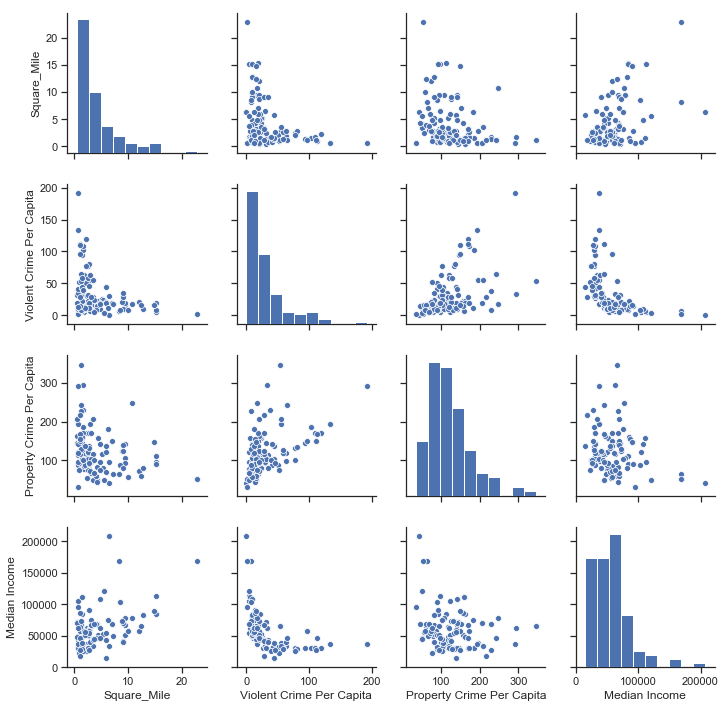

In [296]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(df_la_merge[['Square_Mile','Violent Crime Per Capita','Property Crime Per Capita','Median Income']])

As can be seen, the violent crime rate increases as median income decreases. Almost, the property crime rate has the same trend. This probably shows that most criminal activities happen in areas with lower income. 

# 3. Exploration of Los Angeles Neighborhoods 
After preparing all the data, the location of each neighborhood will be added to the map. Also, the coordinates will be use d to find nearby venues that could be useful to find a place to open the restaurant. 

### 3. A.  Los Angeles City Neighborhoods Map

In [297]:
# Coordinates of the city
# This process of finding location using geolocator is unstable! 
address = 'Los angeles, California'
geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The coordinates of Los Angeles are {}, {}.'.format(latitude, longitude))

The coordinates of Los angeles are 34.0536909, -118.2427666.


The below figure shows all the neighborhood of Los Angeles.

In [298]:
# create map of Toronto using latitude and longitude values
map_la = folium.Map(location=[latitude , longitude], zoom_start=9)

# add markers to map
for  neighb, lat, lng in zip( df_la_merge['Neighborhood'],
               df_la_merge['Latitude'].astype(np.float64),
             df_la_merge['Longitude'].astype(np.float64)):
    label = ' {}, @({}, {})'.format(neighb, lat, lng)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=1,
        parse_html=False).add_to(map_la)
map_la


### 3. B. Target Area Exploration

As there is limitation for using Foursqure API, we will explore the North section of the city (The neighborhood above the latitude of 34.13).

In [19]:
df_la_merge.head()

,Neighborhood,Square_Mile,Longitude,Latitude,Violent Crime Per Capita,Property Crime Per Capita,Median Income
0,Adams-Normandie,0.805350,-118.300208,34.031461,41.6,88.1,29606.0
1,Arleta,3.096179,-118.430757,34.243100,12.0,66.8,65649.0
2,Arlington Heights,1.031415,-118.323408,34.044910,30.0,93.4,31421.0
3,Atwater Village,1.776894,-118.262373,34.131066,4.5,77.6,53872.0
4,Vermont-Slauson,1.442453,-118.290358,33.983914,94.1,145.2,31236.0


In [187]:
df_la_merge= df_la_merge[(df_la_merge['Latitude']>=34.149)]
print('Number of neighborhood at north part: ',df_la_merge.shape[0])
df_la_merge.reset_index(inplace=True, drop=True)


Number of neighborhood at north part:  29


In [188]:
df_la_merge.head()

,Neighborhood,Square_Mile,Longitude,Latitude,Violent Crime Per Capita,Property Crime Per Capita,Median Income
0,Arleta,3.096179,-118.430757,34.243100,12.0,66.8,65649.0
1,Canoga Park,4.348518,-118.601519,34.210855,22.8,157.2,51601.0
2,Chatsworth,15.243597,-118.612354,34.256403,18.6,111.3,84456.0
3,Northridge,9.467487,-118.527969,34.238805,15.6,141.6,67906.0
4,Encino,9.499707,-118.499515,34.156224,9.0,106.8,78529.0


### 3.C. Exploration of Venues in All Neighborhood


To find venues in every neighborhoodm Foursquare Credentials must be defined first.

In [21]:
CLIENT_ID = 'ANXPZN5SSL4BHR50JNGOA2F5CRYFONOU5I3PLPNNHJUZYBG2' # your Foursquare ID
CLIENT_SECRET = '1Q1DT5CAJQH3XIQ4DGN1YCW04QKCVTXSYID13I4KVCJLCDMS' # your Foursquare Secret
VERSION = '20190215'
print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentails:
CLIENT_ID: ANXPZN5SSL4BHR50JNGOA2F5CRYFONOU5I3PLPNNHJUZYBG2
CLIENT_SECRET:1Q1DT5CAJQH3XIQ4DGN1YCW04QKCVTXSYID13I4KVCJLCDMS


Get the top 100 venues within a radius of 500 meters.

In [26]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Let's create a function to repeat the same process to all the neighborhoods in Los Angeles

In [30]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now write the code to run the above function on each neighborhood and create a new dataframe called la_venues.

In [31]:
la_venues = getNearbyVenues(names=df_la_merge['Neighborhood'],
                                   latitudes=df_la_merge['Latitude'],
                                   longitudes=df_la_merge['Longitude']
                                  )

Arleta
Canoga Park
Chatsworth
Northridge
Encino
Granada Hills
Lake Balboa
Lake View Terrace
Mission Hills
North Hills
North Hollywood
Pacoima
Panorama City
Porter Ranch
Reseda
Shadow Hills
Sherman Oaks
Sylmar
Sunland
Sun Valley
Tarzana
Toluca Lake
Tujunga
Valley Glen
Valley Village
Van Nuys
West Hills
Winnetka
Woodland Hills


For better understanding, we are going to visualize all venues for the first neighborhood.

In [235]:
la_venues_first_Neighborhood=la_venues[la_venues['Neighborhood']==la_venues.iloc[0,0]]
la_venues_first_Neighborhood.head(7)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Category Value
0,Arleta,34.2431,-118.430757,Back To The Future Filming Location - McFly's ...,34.243429,-118.433655,Historic Site,0
1,Arleta,34.2431,-118.430757,Redbox,34.242081,-118.426109,Video Store,0
2,Arleta,34.2431,-118.430757,7-Eleven,34.241595,-118.426129,Convenience Store,0
3,Arleta,34.2431,-118.430757,Mariscos El Bigoton,34.241010,-118.427620,Seafood Restaurant,1
4,Arleta,34.2431,-118.430757,Vim Thai Restaurant,34.244394,-118.426429,Thai Restaurant,1
5,Arleta,34.2431,-118.430757,Yummy Donuts & Croissants,34.242344,-118.426159,Bakery,1
6,Arleta,34.2431,-118.430757,T D I - Electricity and Automation Solutions,34.238878,-118.429234,Construction & Landscaping,0


We will show the nighborhood with all its venuse.

In [234]:
neighborhood_latitude = la_venues_first_Neighborhood.loc[0, 'Neighborhood Latitude'] # neighborhood latitude value
neighborhood_longitude = la_venues_first_Neighborhood.loc[0, 'Neighborhood Longitude'] # neighborhood longitude value

neighborhood_name = la_venues_first_Neighborhood.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} (First Neighborhood) are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Arleta (First Neighborhood) are 34.24309999912158, -118.4307575.


In [231]:
map_ven = folium.Map(location=[neighborhood_latitude, neighborhood_longitude], zoom_start=15)
la_venues_first_Neighborhood
folium.CircleMarker(
        [neighborhood_latitude, neighborhood_longitude],
        radius=5,
        popup=folium.Popup("{} - {}".format(neighborhood_latitude, neighborhood_longitude), parse_html=True),
        color='red',
        fill=False,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ven)

for lat, long, v, vc in zip(la_venues_first_Neighborhood['Venue Latitude'],
                           la_venues_first_Neighborhood['Venue Longitude'],
                           la_venues_first_Neighborhood['Venue'],
                           la_venues_first_Neighborhood['Venue Category']):
    label = "{}, Type:({})".format(v, vc)
    popup = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=popup,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ven)
    
map_ven

In [209]:
print('{} venues were returned by Foursquare for the first neighborhood.'.format(la_venues_first_Neighborhood.shape[0]))

7 venues were returned by Foursquare for the first neighborhood.


Now we can investigate all neighborhood venues. Let's check the size and number of unique venues for the generated dataframe.

In [240]:
print('The size of dataframe contains all venues:', la_venues.shape)
print('The number of unique venues:',len(la_venues['Neighborhood'].unique()))

The size of dataframe contains all venues: (271, 8)
The number of unique venues: 26


### 3. D. Categorize Venues

Based on our aim to find the best areas to open the restaurant, the venues are divided into two groups.
* The First group contains all venues that related to food like, restaurant, fast food,...
* The Second group contains all other venues like gym, stores, etc.
To group the venues the categories available on Foursquare website.
<br>
<br>The excel file contains all categories related to food.

In [241]:
all_food_venues=pd.read_excel('Food_Venues.xlsx')
all_food_venues['Venue Category']=all_food_venues['Venue Category'].astype('object')
all_food_venues.head()

,Venue Category,Food Category
0,Abruzzo Restaurant,1
1,Acai House,1
2,Acehnese Restaurant,1
3,Afghan Restaurant,1
4,African Restaurant,1


The column `Venue Category Value` shows the type of venue (Venues related to food:1 and other venues:0).

In [242]:
la_venues_cat=la_venues
la_venues_cat['Venue Category Value']=0
for i in range(len(la_venues_cat)):
   
 for j in range(len(all_food_venues)):

  if la_venues_cat.iloc[i,6]==all_food_venues.iloc[j,0]:
   la_venues_cat['Venue Category Value'].iloc[i] = 1
la_venues_cat.head()


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Category Value
0,Arleta,34.2431,-118.430757,Back To The Future Filming Location - McFly's ...,34.243429,-118.433655,Historic Site,0
1,Arleta,34.2431,-118.430757,Redbox,34.242081,-118.426109,Video Store,0
2,Arleta,34.2431,-118.430757,7-Eleven,34.241595,-118.426129,Convenience Store,0
3,Arleta,34.2431,-118.430757,Mariscos El Bigoton,34.241010,-118.427620,Seafood Restaurant,1
4,Arleta,34.2431,-118.430757,Vim Thai Restaurant,34.244394,-118.426429,Thai Restaurant,1


Let's check how many venues were returned for each neighborhood. Look at only one of the columns.

In [302]:
groupby_food_venues=la_venues_cat.groupby('Neighborhood').count()*0
groupby_food_venues=groupby_food_venues+la_venues_cat[la_venues_cat['Venue Category Value']==1].groupby('Neighborhood').count()
groupby_food_venues.fillna(0, inplace=True)
groupby_food_venues.head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Category Value
Neighborhood,,,,,,,
Arleta,3.0,3.0,3.0,3.0,3.0,3.0,3.0
Canoga Park,5.0,5.0,5.0,5.0,5.0,5.0,5.0
Chatsworth,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Encino,13.0,13.0,13.0,13.0,13.0,13.0,13.0
Lake Balboa,6.0,6.0,6.0,6.0,6.0,6.0,6.0


In [300]:
groupby_other_venues=la_venues_cat.groupby('Neighborhood').count()*0
groupby_other_venues=groupby_other_venues+la_venues_cat[la_venues_cat['Venue Category Value']==0].groupby('Neighborhood').count()
groupby_other_venues.head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Category Value
Neighborhood,,,,,,,
Arleta,4,4,4,4,4,4,4
Canoga Park,5,5,5,5,5,5,5
Chatsworth,2,2,2,2,2,2,2
Encino,9,9,9,9,9,9,9
Lake Balboa,2,2,2,2,2,2,2


The following tables show the total number of each type of venues(Food related or others) for each neighborhood.

In [245]:
All_food_places=pd.DataFrame(data=groupby_food_venues.iloc[:,0])['Neighborhood Latitude'].reset_index()
All_food_places.rename(columns={'Neighborhood Latitude':'sum_food_places'},inplace=True)
All_food_places.head()

,Neighborhood,sum_food_places
0,Arleta,3.0
1,Canoga Park,5.0
2,Chatsworth,0.0
3,Encino,13.0
4,Lake Balboa,6.0


In [246]:
All_other_places=pd.DataFrame(data=groupby_other_venues.iloc[:,0])['Neighborhood Latitude'].reset_index()
All_other_places.rename(columns={'Neighborhood Latitude':'sum_other_places'},inplace=True)
All_other_places.head()

,Neighborhood,sum_other_places
0,Arleta,4
1,Canoga Park,5
2,Chatsworth,2
3,Encino,9
4,Lake Balboa,2


## Analyze Each Neighborhood (Ranking)

In order to rank the venues(two categories), we need to use one hot encoding. This adds new features to the dataset based on `Venue Category` columns  

In [248]:
# one hot encoding
la_onehot = pd.get_dummies(la_venues_cat[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
la_onehot['Neighborhood'] = la_venues_cat['Neighborhood'] 

fixed_columns = [la_onehot.columns[-1]] + list(la_onehot.columns[:-1])
la_onehot = la_onehot[fixed_columns]
la_onehot.head()

,Neighborhood,ATM,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,Bakery,Bank,...,Theater,Thrift / Vintage Store,Tiki Bar,Trail,Ukrainian Restaurant,Video Store,Vietnamese Restaurant,Watch Shop,Wine Bar,Wings Joint
0,Arleta,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Arleta,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,Arleta,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Arleta,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Arleta,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [136]:
la_grouped = la_onehot.groupby('Neighborhood').mean().reset_index()
la_grouped.head()

,Neighborhood,ATM,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,Bakery,Bank,...,Theater,Thrift / Vintage Store,Tiki Bar,Trail,Ukrainian Restaurant,Video Store,Vietnamese Restaurant,Watch Shop,Wine Bar,Wings Joint
0,Arleta,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,...,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.0
1,Canoga Park,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,Chatsworth,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,Encino,0.045455,0.045455,0.0,0.0,0.0,0.0,0.0,0.045455,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,Lake Balboa,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


Again, we need to categorize the dataframe based on the type of venues.

In [139]:
la_grouped_cat=la_grouped
la_grouped_cat.loc[len(la_grouped)]=0

for k in range(la_grouped_cat.shape[1]):
   
 for j in range(len(all_food_venues)):

  if la_grouped_cat.columns[k]==all_food_venues.iloc[j,0]:
    la_grouped_cat.iloc[-1,k] = 1
la_grouped_cat.iloc[-1,0] = 'Venue Category Value'  
la_grouped_cat.tail()

,Neighborhood,ATM,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,Bakery,Bank,...,Theater,Thrift / Vintage Store,Tiki Bar,Trail,Ukrainian Restaurant,Video Store,Vietnamese Restaurant,Watch Shop,Wine Bar,Wings Joint
22,Van Nuys,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071429,0.071429,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.071429,0.0,0.071429
23,West Hills,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
24,Winnetka,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
25,Woodland Hills,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.200000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
26,Venue Category Value,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.000000,0.000000,...,0.000000,0.0,0.0,0.0,1.0,0.0,1.0,0.000000,0.0,1.000000


As you can see, a row temporarily added to the end of dataframe to show the type of venues. The next two dataframe shows the mean of the frequency of occurrence for both venue categories.

In [250]:
la_grouped_food2= la_grouped_cat.T
la_grouped_food1=la_grouped_food2[la_grouped_food2[la_grouped_food2.shape[1]-1]==1]
la_grouped_food=la_grouped_food1. T

la_grouped_food['Neighborhood'] = la_grouped_cat['Neighborhood'] 

fixed_columns = [la_grouped_food.columns[-1]] + list(la_grouped_food.columns[:-1])
la_grouped_food = la_grouped_food[fixed_columns]
la_grouped_food=la_grouped_food[la_grouped_food['Neighborhood']!="Venue Category Value"]
la_grouped_food.head()

,Neighborhood,American Restaurant,Asian Restaurant,Bakery,Breakfast Spot,Burger Joint,Cajun / Creole Restaurant,Chinese Restaurant,Coffee Shop,Deli / Bodega,...,Seafood Restaurant,South American Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Tea Room,Thai Restaurant,Ukrainian Restaurant,Vietnamese Restaurant,Wings Joint
0,Arleta,0,0,0.142857,0,0,0,0,0,0,...,0.142857,0,0,0,0,0,0.142857,0,0,0
1,Canoga Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0.1,0,0,0,0,0,0
2,Chatsworth,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Encino,0.0454545,0,0.0454545,0,0,0,0.0909091,0,0.0909091,...,0,0,0.0454545,0,0,0,0.0454545,0,0,0
4,Lake Balboa,0,0,0,0,0.125,0,0,0,0,...,0.125,0,0.125,0,0,0,0,0,0,0


In [251]:
la_grouped_other2= la_grouped_cat.T
la_grouped_other1=la_grouped_other2[la_grouped_other2[la_grouped_other2.shape[1]-1]==0]
la_grouped_other=la_grouped_other1.T

la_grouped_other['Neighborhood'] = la_grouped_cat['Neighborhood'] 

fixed_columns = [la_grouped_other.columns[-1]] + list(la_grouped_other.columns[:-1])
la_grouped_other = la_grouped_other[fixed_columns]
la_grouped_other=la_grouped_other[la_grouped_other['Neighborhood']!="Venue Category Value"]
la_grouped_other.head()

,Neighborhood,ATM,Art Gallery,Arts & Crafts Store,Athletics & Sports,Automotive Shop,Bank,Bar,Boutique,Business Service,...,State / Provincial Park,Supermarket,Supplement Shop,Theater,Thrift / Vintage Store,Tiki Bar,Trail,Video Store,Watch Shop,Wine Bar
0,Arleta,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.142857,0,0
1,Canoga Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Chatsworth,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Encino,0.0454545,0,0,0,0,0,0,0,0,...,0.0454545,0,0.0454545,0,0,0,0,0,0,0
4,Lake Balboa,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


First, let's write a function to sort the venues in descending order

In [142]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 2 venues for each neighborhood

In [253]:
num_top_venues = 2
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Food Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Food Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted_food = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_food['Neighborhood'] = la_grouped_food['Neighborhood']

for ind in np.arange(la_grouped_food.shape[0]):
    neighborhoods_venues_sorted_food.iloc[ind, 1:] = return_most_common_venues(la_grouped_food.iloc[ind, :], num_top_venues)
neighborhoods_venues_sorted_food.reset_index(drop=True, inplace=True)

neighborhoods_venues_sorted_food=neighborhoods_venues_sorted_food[neighborhoods_venues_sorted_food.Neighborhood != 'Venue Category Value']
neighborhoods_venues_sorted_food.head()

,Neighborhood,1st Most Common Food Venue,2nd Most Common Food Venue
0,Arleta,Thai Restaurant,Bakery
1,Canoga Park,Mexican Restaurant,Ice Cream Shop
2,Chatsworth,Wings Joint,Vietnamese Restaurant
3,Encino,Japanese Restaurant,Deli / Bodega
4,Lake Balboa,Mexican Restaurant,Burger Joint


In [254]:
num_top_venues = 2

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most  Common Other Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most  Common Other Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted_other = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_other['Neighborhood'] = la_grouped_other['Neighborhood']

for ind in np.arange(la_grouped_other.shape[0]):
    neighborhoods_venues_sorted_other.iloc[ind, 1:] = return_most_common_venues(la_grouped_other.iloc[ind, :], num_top_venues)
neighborhoods_venues_sorted_other.reset_index(drop=True, inplace=True)

neighborhoods_venues_sorted_other=neighborhoods_venues_sorted_other[neighborhoods_venues_sorted_other.Neighborhood != 'Venue Category Value']
neighborhoods_venues_sorted_other.head()

,Neighborhood,1st Most Common Other Venue,2nd Most Common Other Venue
0,Arleta,Video Store,Historic Site
1,Canoga Park,Sports Bar,Furniture / Home Store
2,Chatsworth,Park,Wine Bar
3,Encino,ATM,Supplement Shop
4,Lake Balboa,Convenience Store,Pharmacy


Now to have all information in one data frame we will merge all data related to ranking.

In [255]:
neighborhoods_venues_sorted=neighborhoods_venues_sorted_food.merge(All_food_places, on = 'Neighborhood')
neighborhoods_venues_sorted=neighborhoods_venues_sorted.merge(neighborhoods_venues_sorted_other, on = 'Neighborhood')
neighborhoods_venues_sorted=neighborhoods_venues_sorted.merge(All_other_places, on = 'Neighborhood')
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Food Venue,2nd Most Common Food Venue,sum_food_places,1st Most Common Other Venue,2nd Most Common Other Venue,sum_other_places
0,Arleta,Thai Restaurant,Bakery,3.0,Video Store,Historic Site,4
1,Canoga Park,Mexican Restaurant,Ice Cream Shop,5.0,Sports Bar,Furniture / Home Store,5
2,Chatsworth,Wings Joint,Vietnamese Restaurant,0.0,Park,Wine Bar,2
3,Encino,Japanese Restaurant,Deli / Bodega,13.0,ATM,Supplement Shop,9
4,Lake Balboa,Mexican Restaurant,Burger Joint,6.0,Convenience Store,Pharmacy,2


Before conducting clustering we will prepare the input dataframe(`df_final`). It contains neighborhood area size, crime, total number of food and other venues. The column  of neighborhood name will be deleted before using in clustering. We will use the data frame related to the ranking of venues during the investigation of resulted clusters.    

In [257]:
# Merge the dataframes
df_final=df_la_merge.merge(All_food_places, on = 'Neighborhood')
df_final=df_final.merge(All_other_places, on = 'Neighborhood')
del df_final['Latitude']
del df_final['Longitude']
df_final.head()

,Neighborhood,Square_Mile,Violent Crime Per Capita,Property Crime Per Capita,Median Income,sum_food_places,sum_other_places
0,Arleta,3.096179,12.0,66.8,65649.0,3.0,4
1,Canoga Park,4.348518,22.8,157.2,51601.0,5.0,5
2,Chatsworth,15.243597,18.6,111.3,84456.0,0.0,2
3,Northridge,9.467487,15.6,141.6,67906.0,11.0,2
4,Encino,9.499707,9.0,106.8,78529.0,13.0,9


# 4) Cluster Neighborhoods
K-Means is a type of partitioning clustering which divides the data into K non-overlapping sphere-like clusters without any labels. It is relatively efficient on medium to large-sized data sets. This method tries to minimize intra-cluster distances and maximize  inter-cluster distances. To know how are the data points in a cluster, we need to use dissimilarity measures such as Euclidean distance or Average distance. The K means algorithm steps are as follow:

Randomly Initialize centroids (representative points of each cluster)
Distance calculation (Distance Matrix as a dissimilarity measure) to find the nearest centroid to data points
Assign each point to the nearest centroid
Update the centroids for every cluster
Repeat until there is no more change (move the centroids, calculate the distances from new centroids and assign data points to the nearest centroid) 

In [261]:
# Uncomment when you want to repeat the clustering. It removes the cluster labels.
#del neighborhoods_venues_sorted['Cluster Labels']

In [262]:
# set number of clusters
kclusters =3
la_grouped_clustering = df_final.drop('Neighborhood', 1)

# Uncomment if you want to remove the specific column from the final data frame
#la_grouped_clustering = la_grouped_clustering.drop('Square_Mile', 1)
#la_grouped_clustering = la_grouped_clustering.drop('Property Crime Per Capita', 1)
#la_grouped_clustering = la_grouped_clustering.drop('Violent Crime Per Capita', 1)
#la_grouped_clustering = la_grouped_clustering.drop('Median Income', 1)

# Normalization
la_grouped_clustering = StandardScaler().fit_transform(la_grouped_clustering)

# Run clustering:
# K-mean method
kmeans = KMeans( n_clusters=kclusters, random_state=0, init='random',max_iter=3000,n_init=1).fit(la_grouped_clustering)
# Check cluster labels generated for each row in the dataframe
kmeans.labels_

# Uncomment if you want to use agglomerative clustering method
# Agglomerative method
# agglomerative_clustering = AgglomerativeClustering(kclusters).fit(la_grouped_clustering)
# agglomerative_clustering.labels_

array([2, 1, 0, 0, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 0, 1, 2, 1, 1,
       1, 0, 2, 0])

Let's create a new dataframe that includes the cluster as well as the top venues for each neighborhood.

In [263]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# Uncomment if you want to use agglomerative clustering method
#neighborhoods_venues_sorted_food.insert(0, 'Cluster Labels', agglomerative_clustering.labels_)

# Merge data to add latitude/longitude for each neighborhood
df_la = df_la_merge.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
df_la.dropna(inplace=True)
df_la.reset_index(inplace=True, drop=True)
temp = df_la["Cluster Labels"].apply(lambda x: int(x) if x == x else "")
df_la["Cluster Labels"]=temp
df_la.head() 

,Neighborhood,Square_Mile,Longitude,Latitude,Violent Crime Per Capita,Property Crime Per Capita,Median Income,Cluster Labels,1st Most Common Food Venue,2nd Most Common Food Venue,sum_food_places,1st Most Common Other Venue,2nd Most Common Other Venue,sum_other_places
0,Arleta,3.096179,-118.430757,34.243100,12.0,66.8,65649.0,2,Thai Restaurant,Bakery,3.0,Video Store,Historic Site,4.0
1,Canoga Park,4.348518,-118.601519,34.210855,22.8,157.2,51601.0,1,Mexican Restaurant,Ice Cream Shop,5.0,Sports Bar,Furniture / Home Store,5.0
2,Chatsworth,15.243597,-118.612354,34.256403,18.6,111.3,84456.0,0,Wings Joint,Vietnamese Restaurant,0.0,Park,Wine Bar,2.0
3,Northridge,9.467487,-118.527969,34.238805,15.6,141.6,67906.0,1,American Restaurant,Fast Food Restaurant,11.0,Pub,College Theater,2.0
4,Encino,9.499707,-118.499515,34.156224,9.0,106.8,78529.0,0,Japanese Restaurant,Deli / Bodega,13.0,ATM,Supplement Shop,9.0


 let's visualize the resulting clusters

In [181]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=8)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_la['Latitude'], df_la['Longitude'], df_la['Neighborhood'], df_la['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=rainbow[cluster-2],
        fill=True,
        fill_color=rainbow[cluster-2],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# 5)Clusters Investigation
Investigation of clusters is one of the most important issues in cluster analysis to justify the selection of the right candidates.

### Cluster 1

In [173]:
C1=df_la.loc[df_la['Cluster Labels'] == 0, df_la.columns[[1] + list(range(4, df_la.shape[1]))]]
C1.head()

,Square_Mile,Violent Crime Per Capita,Property Crime Per Capita,Median Income,Cluster Labels,1st Most Common Food Venue,2nd Most Common Food Venue,sum_food_places,1st Most Common Other Venue,2nd Most Common Other Venue,sum_other_places
2,15.243597,18.6,111.3,84456.0,0,Wings Joint,Vietnamese Restaurant,0.0,Park,Wine Bar,2.0
4,9.499707,9.0,106.8,78529.0,0,Japanese Restaurant,Deli / Bodega,13.0,ATM,Supplement Shop,9.0
17,8.790902,20.1,124.4,73195.0,0,Wings Joint,Vietnamese Restaurant,0.0,Grocery Store,Wine Bar,1.0
23,8.528078,8.4,87.9,103008.0,0,Italian Restaurant,Food,2.0,Martial Arts Dojo,Theater,4.0
25,14.768310,16.1,148.5,89946.0,0,Asian Restaurant,Bakery,2.0,Business Service,Gym / Fitness Center,3.0


In [269]:
C1.describe()

,Square_Mile,Violent Crime Per Capita,Property Crime Per Capita,Median Income,Cluster Labels,sum_food_places,sum_other_places
count,5.000000,5.000000,5.000000,5.000000,5.0,5.000000,5.000000
mean,11.366119,14.440000,115.780000,85826.800000,0.0,3.400000,3.800000
std,3.345872,5.435347,22.488375,11476.724171,0.0,5.458938,3.114482
min,8.528078,8.400000,87.900000,73195.000000,0.0,0.000000,1.000000
25%,8.790902,9.000000,106.800000,78529.000000,0.0,0.000000,2.000000
50%,9.499707,16.100000,111.300000,84456.000000,0.0,2.000000,3.000000
75%,14.768310,18.600000,124.400000,89946.000000,0.0,2.000000,4.000000
max,15.243597,20.100000,148.500000,103008.000000,0.0,13.000000,9.000000


This cluster contains 5 neighborhoods. The average area size of this cluster is around 11 which is the highest among all clusters. the violent and property crime rates are 14.5 and 115.8, respectively which introduce this cluster as the highest crime rate after cluster 2. The income range for this cluster is 73000 to 103000. The ratio of the number of food-related venues to other kinds of venues is 0.9.   

### Cluster 2

In [267]:
C2=df_la.loc[df_la['Cluster Labels'] == 1, df_la.columns[[1] + list(range(4, df_la.shape[1]))]]
C2.head()

8

In [176]:
C2.describe()

,Square_Mile,Violent Crime Per Capita,Property Crime Per Capita,Median Income,Cluster Labels,sum_food_places,sum_other_places
count,8.000000,8.00000,8.000000,8.000000,8.0,8.000000,8.000000
mean,5.398485,16.81250,127.675000,58798.000000,1.0,9.375000,9.375000
std,3.350725,7.00213,22.173714,11847.724941,0.0,5.153016,6.738747
min,1.217228,8.20000,95.100000,41134.000000,1.0,4.000000,2.000000
25%,2.865741,11.00000,117.025000,50244.500000,1.0,5.750000,4.250000
50%,4.577031,17.55000,133.750000,60403.000000,1.0,7.500000,8.000000
75%,9.029916,20.47500,140.625000,68342.250000,1.0,12.500000,14.000000
max,9.467487,28.10000,157.200000,73111.000000,1.0,17.000000,20.000000


This cluster contains 8 neighborhoods. The average area size of this cluster is around 5.4 which is the lowest among all clusters. the violent and property crime rates are 16.8 and 127.7, respectively which is the highest crime rate after cluster 2. The income range for this cluster is 41000 to 73000. This is the lowest income rate among all clusters. The ratio of the number of food-related venues to other kinds of venues is 1. It means that on average the number of venues related to food is equal to the number of other venues like gym, etc. 

### Cluster 3

In [272]:
C3=df_la.loc[df_la['Cluster Labels'] == 2, df_la.columns[[1] + list(range(4, df_la.shape[1]))]]

In [178]:
C3.describe()

,Square_Mile,Violent Crime Per Capita,Property Crime Per Capita,Median Income,Cluster Labels,sum_food_places,sum_other_places
count,13.000000,13.000000,13.000000,13.000000,13.0,13.000000,13.000000
mean,6.182739,15.807692,77.484615,62510.230769,2.0,3.461538,3.076923
std,2.864045,6.130180,21.443097,20219.765294,0.0,3.256158,2.139374
min,3.096179,3.900000,50.400000,42791.000000,2.0,0.000000,1.000000
25%,4.004117,12.000000,60.200000,51290.000000,2.0,1.000000,2.000000
50%,5.586170,17.500000,69.700000,58001.000000,2.0,2.000000,2.000000
75%,7.137554,19.800000,92.800000,65783.000000,2.0,6.000000,4.000000
max,12.456388,23.800000,122.900000,121428.000000,2.0,9.000000,9.000000


This cluster contains 13 neighborhoods. The average area size of this cluster is around 6.2. the violent and property crime rates are 15.8 and 77.5, respectively which is the lowest crime rate among all clusters. The income range for this cluster is 42000 to 121000. The ratio of the number of food-related venues to other kinds of venues is 0.88.

# Conclusion

During this analysis, different kind of data contains area size, violent crime rate, property crime rate, income rate, number of food-related venues and number of other types of venues. K-mean and Agglomerative methods were used to find the best clusters that could able to group neighborhoods, precisely. Also, different combinations of the above data were selected to find the best results. Finally, K-mean algorithm shows the best performance.  
Based on the above cluster descriptions, cluster 3 is the best areas to open a restaurant. This cluster has minimum criminal rates, minimum food-related venues to other type ratio and wide range of incomes. The next table shows the neighborhoods belong to this cluster.     

In [304]:
C3

,Square_Mile,Violent Crime Per Capita,Property Crime Per Capita,Median Income,Cluster Labels,1st Most Common Food Venue,2nd Most Common Food Venue,sum_food_places,1st Most Common Other Venue,2nd Most Common Other Venue,sum_other_places
0,3.096179,12.0,66.8,65649.0,2,Thai Restaurant,Bakery,3.0,Video Store,Historic Site,4.0
6,3.187498,15.9,102.9,75675.0,2,Wings Joint,Vietnamese Restaurant,0.0,Church,Park,2.0
7,5.308118,23.2,79.7,52456.0,2,Pizza Place,Fast Food Restaurant,2.0,Grocery Store,River,2.0
8,5.869115,21.2,122.9,42791.0,2,Latin American Restaurant,Indian Restaurant,9.0,Wine Bar,Mobile Phone Shop,9.0
9,7.137554,18.0,65.5,49066.0,2,Breakfast Spot,Food Truck,2.0,Home Service,Wine Bar,1.0
10,3.647996,23.8,101.2,44468.0,2,Mexican Restaurant,Wings Joint,1.0,Skating Rink,Park,3.0
11,5.586170,3.9,50.4,121428.0,2,American Restaurant,Vietnamese Restaurant,1.0,Park,Electronics Store,3.0
12,5.865491,18.5,69.7,54771.0,2,Vietnamese Restaurant,Fast Food Restaurant,9.0,Convenience Store,Supermarket,2.0
14,12.456388,15.3,60.2,65783.0,2,Pizza Place,Mexican Restaurant,7.0,Business Service,Garden Center,1.0
15,4.004117,7.9,60.2,68720.0,2,Food Court,Wings Joint,1.0,Concert Hall,Park,2.0


Within the selected cluster and based on ranked food venues or even other venues we can offer the type of food-related venues. It should be noted that in this table the two top venues are shown. One may consider the less common type of venues. Looking at both most common and less common food-related is recommended.  